In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import *
from pickle_cache import PickleCache
import pandas as pd
from experiment_widgets import VariableTracingExperiment
import json
from random import sample, randint, choices
import string
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
import seaborn as sns
import torch.distributions.constraints as constraints

sns.set()

pcache = PickleCache()

In [3]:
all_names = string.ascii_lowercase
all_operators = ['+', '-']

def generate_trial(N):
    names = sample(all_names, k=N)
    variables = [
        {'variable': names[i], 'value': randint(1, 9)}
        for i in range(N)
    ]

    expr_var_order = sample(variables, k=len(variables))
    operators = choices(all_operators, k=N-1)
    expr_list = []
    expr_value = expr_var_order[0]['value']
    for i in range(N):
        if i > 0:
            op = operators[i-1]
            expr_value = eval(f"{expr_value} {op} {expr_var_order[i]['value']}")
            expr_list.append(op)
        expr_list.append(expr_var_order[i]['variable'])
    expr = ' '.join(expr_list)
    
    return {
        'variables': variables, 
        'expression': expr,
        'expression_value': expr_value
    }

def exp_name(N_var, N_trials):
    return f'vartrace_{N_var}_{N_trials}'

In [4]:
N_var = 7
N_trials = 10

experiment = {
    'trials': [generate_trial(N_var) for _ in range(N_trials)],
    'between_trials_time': 1000
}

exp = VariableTracingExperiment(experiment=json.dumps(experiment), results='[]')

def on_result_change(_):
    pcache.set(exp_name(N_var, N_trials), {
        'experiment': experiment,
        'results': json.loads(exp.results)
    })
    
#exp.observe(on_result_change)

exp

VariableTracingExperiment(experiment='{"trials": [{"variables": [{"variable": "x", "value": 7}, {"variable": "…

In [33]:
def process_results(N_var, N_trials):
    data = pcache.get(exp_name(N_var, N_trials))
    experiment = data['experiment']
    results = data['results']
    
    df = []
    for (trial, result) in zip(experiment['trials'], results):
        try:
            response = int(result['response'])
        except ValueError:
            response = -1000
                   
        correct = trial['expression_value'] == response
        df.append({
            'N_var': N_var,
            'correct': correct,
            'switches': result['switch_count']//2,
            'response_time': result['response_time']/1000.,
            'type': 'actual'
        })
    return pd.DataFrame(df)

process_results(N_var, N_trials)

,N_var,correct,switches,response_time,type
0,7,True,3,25.240,actual
1,7,True,1,20.318,actual
2,7,False,2,18.790,actual
3,7,True,3,24.138,actual
4,7,True,2,26.821,actual
5,7,True,1,13.549,actual
6,7,True,1,15.813,actual
7,7,True,1,11.606,actual
8,7,True,3,35.147,actual
9,7,True,1,18.842,actual


In [34]:
all_exp = [2, 3, 4, 5, 6, 7]
results = pd.concat([process_results(N_var, 10) for N_var in all_exp])

Text(0, 0.5, 'Response time (s)')

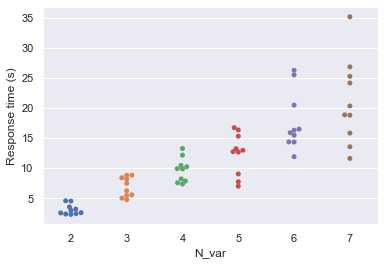

In [7]:
ax = sns.swarmplot(data=results, x='N_var', y='response_time')
ax.set_ylabel('Response time (s)')

In [8]:
import statsmodels.formula.api as smf
data = results.groupby('N_var').response_time.nlargest(2).reset_index().groupby('N_var').mean().reset_index()
#smf.ols('response_time ~ np.power(N_var,2)', data=data).fit().summary()

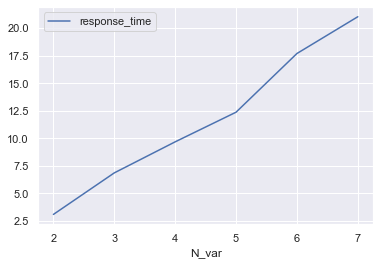

In [9]:
results.groupby('N_var').mean().plot(y='response_time')

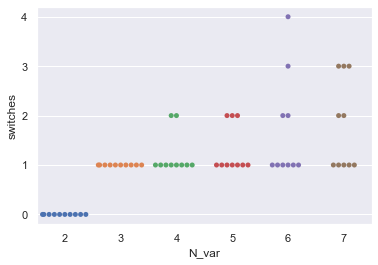

In [10]:

ax = sns.swarmplot(data=results, x='N_var', y='switches')
ax.set_yticks(list(range(5)))

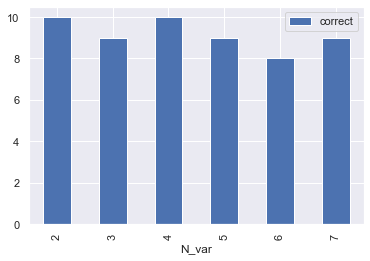

In [11]:
results.groupby('N_var').sum().plot.bar(y='correct')

In [12]:
#     params = {
#     name: {
#         'mu': pyro.param(f'{name}_mu', tensor(init_mu)),
#         'sigma': pyro.param(f'{name}_sigma', tensor(init_sigma))
#     }   
#     for name, (init_mu, init_sigma) in params.items()
# }


In [13]:
params = {
    'number_cost': (0.2, 0.1),
    'var_cost': (0.2, 0.1),
    'binop_cost': (2.0, 1.0),
    'assign_cost': (0.2, 0.1)
}

def model(trial):
    param_values = {
        name: {
            'mu': pyro.param(f'{name}_mu', tensor(init_mu), constraint=constraints.positive),
            'sigma': pyro.param(f'{name}_sigma', tensor(init_sigma), constraint=constraints.positive)
        }
        for name, (init_mu, init_sigma) in params.items()
    }
    
    wm = WorkingMemory()
    src = [
        f"{v['variable']} = {v['value']}"
        for v in trial['variables']
    ] + [trial['expression']]
    prog = parse('\n'.join(src))

    visitor = TraceVisitor(wm=wm, ctx=prog.statements[:-1], params=param_values)
    visitor.visit(prog.statements[-1])
    reset_name_counters()
    
    return visitor.time

In [14]:
trials = []
results2 = []
for N_var in all_exp:
    data = pcache.get(exp_name(N_var, N_trials))
    trials.extend(data['experiment']['trials'])
    results2.extend(data['results'])

In [43]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDelta
from pyro.poutine import trace
from functools import reduce

pyro.clear_param_store()

class Loss(Trace_ELBO):
    def loss_and_grads(self, model, _):
        total_loss = tensor(0.)
        for i in range(len(trials)):
            loss = (model(trials[i]) - tensor(results2[i]['response_time'])/1000.) 
            loss = loss ** 2
            total_loss += loss
        total_loss.backward()
        return total_loss
    
svi = SVI(model, None, Adam({'lr': 0.01}), loss=Loss())
loss_over_time = []
for i in tqdm(range(100)):
    loss = []
    loss.append(svi.step())
        
    loss_over_time.append(pd.Series(loss).mean())
    
    if i % 5 == 0:
        print(loss_over_time[-1], pyro.param('binop_cost_mu').item())

1281.36669921875 1.9800996780395508
3118.933837890625 1.888255000114441
1666.1715087890625 1.803974986076355
1733.1748046875 1.7290558815002441
1980.9595947265625 1.6685775518417358
1754.6148681640625 1.626441240310669
1535.4342041015625 1.595388650894165
3722.1337890625 1.5770727396011353
2450.185546875 1.5585237741470337
2034.6051025390625 1.5525152683258057
2136.262451171875 1.557250738143921
2066.330322265625 1.5684850215911865
3755.469970703125 1.5836488008499146
1771.703125 1.590029001235962
2921.274658203125 1.5841701030731201
2165.439208984375 1.570756435394287
1494.1783447265625 1.5637600421905518
3755.79541015625 1.563080072402954
2111.93896484375 1.5726754665374756
1412.922607421875 1.585498332977295



In [ ]:
pd.Series(loss_over_time).plot()

In [23]:
params

{'number_cost': (0.2, 0.1),
 'var_cost': (0.2, 0.1),
 'binop_cost': (2.0, 1.0),
 'assign_cost': (0.2, 0.1)}

In [42]:
{
    name: {
        'mu': pyro.param(f'{name}_mu', tensor(init_mu)).item(),
        'sigma': pyro.param(f'{name}_sigma', tensor(init_sigma)).item()
    }
    for name, (init_mu, init_sigma) in params.items()
}

{'number_cost': {'mu': 0.18888205289840698, 'sigma': 0.08806491643190384},
 'var_cost': {'mu': 0.18988081812858582, 'sigma': 0.093576580286026},
 'binop_cost': {'mu': 1.8909205198287964, 'sigma': 0.8368642926216125},
 'assign_cost': {'mu': 0.18862661719322205, 'sigma': 0.1197272464632988}}

In [31]:
def simulate_many(model):
    return pd.DataFrame([
        {'N_var': N_var, 'response_time': model(generate_trial(N_var)).item(), 'type': 'simulated'}
        for N_var in tqdm(range(2, 8))
        for _ in range(200)
    ])

def stats(results, prefix):
    group = results.groupby('N_var')    
    return pd.DataFrame({
        f'{prefix}_median': group.median().response_time,
        f'{prefix}_mean': group.mean().response_time,
        f'{prefix}_std': group.std().response_time
    })

def show_results(results_sim):
    print(stats(results, 'actual'))
    print(stats(results_sim, 'sim'))
    ax = sns.boxplot(data=results_sim, x='N_var', y='response_time')
    ax.set_ylabel('Response time (s)')


       actual_median  actual_mean  actual_std
N_var                                        
2             2.7690       3.1004    0.856344
3             6.8465       6.8672    1.633656
4             9.8850       9.6823    1.981255
5            12.8400      12.3691    3.436759
6            16.0865      17.6909    4.822709
7            19.5800      21.0264    7.012014
       sim_median   sim_mean    sim_std
N_var                                  
2        3.404915   3.482996   0.876287
3        6.427171   6.775398   1.946373
4        9.513648  10.280121   3.313430
5       12.311915  14.049466   5.000359
6       15.102984  17.436189   7.379502
7       18.722228  23.949437  11.379788


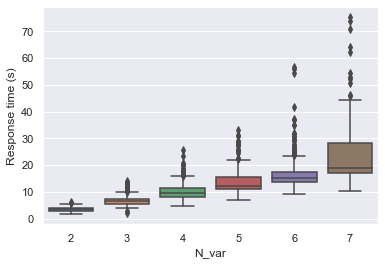

In [32]:
results_sim = simulate_many(model)
show_results(results_sim)

Text(0, 0.5, 'Response time (s)')

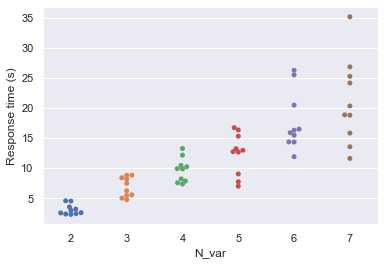

In [27]:
ax = sns.swarmplot(data=results, x='N_var', y='response_time')
ax.set_ylabel('Response time (s)')

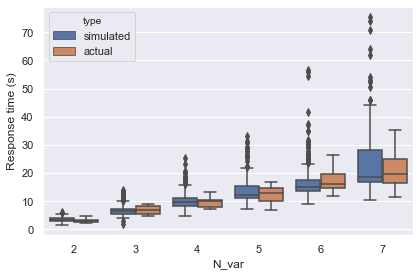

In [41]:
results_all = pd.concat([results_sim, results])
ax = sns.boxplot(data=results_all, x='N_var', y='response_time', hue='type')
ax.set_ylabel('Response time (s)')
plt.tight_layout()
plt.savefig('variable_tracing.png', dpi=300)